In [1]:
from transformer_lens import HookedTransformer
import transformer_lens.utils as utils

d:\Doctorado\Papers\Para EL paper\Workspace\synthetic_gender_datasets\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np
import re
import random
import json
from datasets import Dataset

`get_token_position`: Get the position of a single_token in a string or sequence of tokens.

In [3]:
df = pd.read_csv("../datasets/names.csv")
df.head()

,name,gender,number,gpt2-small
0,James,M,5122407,3700
1,John,M,5096818,1757
2,Robert,M,4803587,5199
3,Michael,M,4326215,3899
4,Mary,F,4118147,5335


In [8]:
#df = df.drop_duplicates(subset="name", keep=False)
df[ df["name"] == "Jamie" ]

,name,gender,number,gpt2-small
260,Jamie,F,266522,17826
699,Jamie,M,84703,17826


In [56]:
df["gpt2-small-size"] = df["gpt2-small"].apply(lambda x: len(x.split(",")))

In [57]:
import matplotlib.pyplot as plt

df["number"].describe()

count    1.053870e+05
mean     3.236929e+03
std      5.241932e+04
min      5.000000e+00
25%      1.100000e+01
50%      4.400000e+01
75%      2.310000e+02
max      5.122407e+06
Name: number, dtype: float64

In [58]:
df = df[df["number"] > 231]

In [4]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer


In [60]:
def to_token_ids(model: HookedTransformer, name: str) -> str:
    """
    Converts a given name string into a comma-separated string of token IDs using the provided model.

    Args:
        model (HookedTransformer): The language model used for tokenization.
        name (str): The name to be tokenized.

    Returns:
        str: A comma-separated string of token IDs representing the input name.
    """
    tokens = model.to_tokens(f" {name}", prepend_bos=False)[0].tolist()
    return ",".join([str(t) for t in tokens])

# df["gpt2-small"] = df["name"].apply(lambda x: to_token_ids(model, x))

In [15]:
example_prompt = "Is Jimmie around here?\n-No,"
example_answer = " he"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True, top_k=10)

Tokenized prompt: ['<|endoftext|>', 'Is', ' Jim', 'mie', ' around', ' here', '?', '\n', '-', 'No', ',']
Tokenized answer: [' he']


Performance on answer token:
Rank: 0        Logit: 14.90 Prob: 21.66% Token: | he|

Top 0th token. Logit: 14.90 Prob: 21.66% Token: | he|
Top 1th token. Logit: 14.58 Prob: 15.80% Token: | Jim|
Top 2th token. Logit: 14.01 Prob:  8.95% Token: | I|
Top 3th token. Logit: 13.93 Prob:  8.25% Token: | but|
Top 4th token. Logit: 13.71 Prob:  6.64% Token: | not|
Top 5th token. Logit: 13.12 Prob:  3.66% Token: | it|
Top 6th token. Logit: 12.83 Prob:  2.74% Token: | no|
Top 7th token. Logit: 12.12 Prob:  1.35% Token: | that|
Top 8th token. Logit: 12.08 Prob:  1.29% Token: | we|
Top 9th token. Logit: 11.82 Prob:  1.00% Token: | and|


Ranks of the answer tokens: [(' he', 0)]

In [62]:
def fill_prompt(prompt: str, template_config: dict) -> str:
    """
    Fills a prompt template by replacing placeholders with actual values.

    Args:
        prompt (str): The prompt template containing placeholders in square brackets.
        name (str): The name to insert into the prompt.
        template_config (dict): Dictionary with possible replacements for placeholders.

    Returns:
        str: The filled prompt with all placeholders replaced.
    """
    elems = re.findall(r"\[(.*?)\]",prompt)
    for elem in elems:
        if elem in template_config:
            prompt = re.sub(rf"\[{elem}\]", random.choice(template_config[elem]), prompt)

    return prompt

def get_ans_tokens(ans: dict, model: HookedTransformer) -> dict:
    """
    Converts answer strings to their corresponding token IDs using the model.

    Args:
        ans (dict): Dictionary mapping keys (e.g., gender) to answer strings.
        model (HookedTransformer): The language model used for tokenization.

    Returns:
        dict: Dictionary mapping keys to the first token ID of each answer string.
    """
    return { k: model.to_tokens(f" {v}", prepend_bos=False)[0].tolist()[0] for k,v in ans.items() }

def get_opposite_gender(gender: str) -> str:
    """
    Returns the opposite gender.

    Args:
        gender (str): "M" for male or "F" for female.

    Returns:
        str: "F" if input is "M", otherwise "M".
    """
    return "F" if gender=="M" else "M"

def get_token_pos(prompt: str, token_str: str) -> str:
    """
    Finds the positions of tokens in a prompt.

    Args:
        prompt (str): The prompt string.
        token_str (str): Comma-separated string of token IDs.

    Returns:
        list: List of positions of each token in the prompt.
    """
    tokens = token_str.split(",")
    pos = [ model.get_token_position(single_token=int(token), input=prompt, prepend_bos=True) for token in tokens ]
    return ",".join([str(p) for p in pos])

def create_dataset(model: HookedTransformer, df: pd.DataFrame, template_config: dict, dataset_size: int = 1000, subject_token_size: int = 2) -> dict:
    """
    Creates a dataset dictionary for language model probing.

    Args:
        model (HookedTransformer): The language model.
        df (pd.DataFrame): DataFrame containing names and metadata.
        template_config (dict): Configuration for templates and answers.
        dataset_size (int): Number of samples to generate.
        subject_token_size (int): Number of tokens for subject names.

    Returns:
        dict: Dictionary containing dataset fields for further processing.
    """
    ans_tokens = get_ans_tokens(template_config["ans"], model)
    prompt = random.choice(template_config["templates"])

    all_males   = df[ (df["gender"] == "M") & (df["gpt2-small-size"] == subject_token_size) ] 
    all_females = df[ (df["gender"] == "F") & (df["gpt2-small-size"] == subject_token_size) ] 

    males   = all_males.sample(n=dataset_size // 2, weights="number", replace=True)
    females = all_females.sample(n=dataset_size // 2, weights="number", replace=True)
    
    data_1 = pd.concat([males, females], axis=0).reset_index(drop=True)
    data_2 = pd.concat([females, males], axis=0).reset_index(drop=True)
    data_1 = data_1.add_suffix("_1")
    data_2 = data_2.add_suffix("_2")

    data = pd.concat([data_1, data_2], axis=1).reset_index(drop=True)

    data["pre-prompt"] = [fill_prompt(prompt, template_config) for _ in range(len(data) // 2)] * 2
    data["prompt"]     = data.apply(lambda row: re.sub(rf"\[name\]", row["name_1"], row["pre-prompt"]), axis=1) 
    data["corrupted_prompt"] = data.apply(lambda row: re.sub(rf"\[name\]", row["name_2"], row["pre-prompt"]), axis=1) 
    data["expected_token"] = data.apply(lambda row: template_config["ans"][row["gender_1"]], axis=1)
    data["unexpected_token"] = data.apply(lambda row: template_config["ans"][row["gender_2"]], axis=1)
    data["expected_token_id"] = data.apply(lambda row: ans_tokens[row["gender_1"]], axis=1)
    data["unexpected_token_id"] = data.apply(lambda row: ans_tokens[row["gender_2"]], axis=1)
    data["subject_token_pos"] = data.apply(lambda row: get_token_pos(row["prompt"], row["gpt2-small_1"]), axis=1)
    data["prompt_type"] = data["subject_token_pos"].astype('category').cat.codes

    cols = ["prompt", "corrupted_prompt", "expected_token", "unexpected_token", "expected_token_id", "unexpected_token_id", "subject_token_pos", "prompt_type"]
    return data[ cols ].to_dict(orient="list")

In [74]:
# CONFIG
dataset = "subject_pron"
dataset_size = 1000
subject_token_sizes = [1,2,3]

In [75]:
with open("../src/json/templates.json", "r", encoding="utf-8") as f:
    jdata = json.load(f)
    datasets = []

    for subject_token_size in subject_token_sizes:
        print(f"Creating dataset for subject_token_size={subject_token_size}...")
        mydict = create_dataset(model, df, jdata[dataset], 
                                dataset_size=dataset_size, subject_token_size=subject_token_size)
        ds = Dataset.from_dict(mydict)
        ds.save_to_disk(f"../datasets/{dataset}_{subject_token_size}_tokens")
        datasets.append(ds)

Creating dataset for subject_token_size=1...


Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 103755.20 examples/s]


Creating dataset for subject_token_size=2...


Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 53337.54 examples/s]


Creating dataset for subject_token_size=3...


Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 327270.91 examples/s]


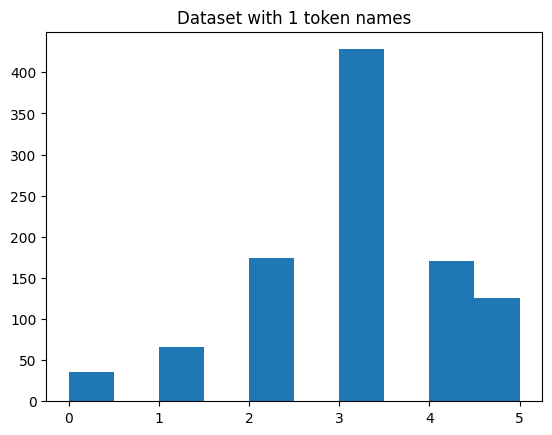

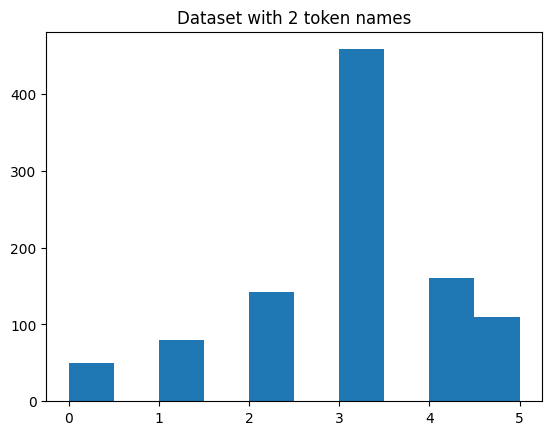

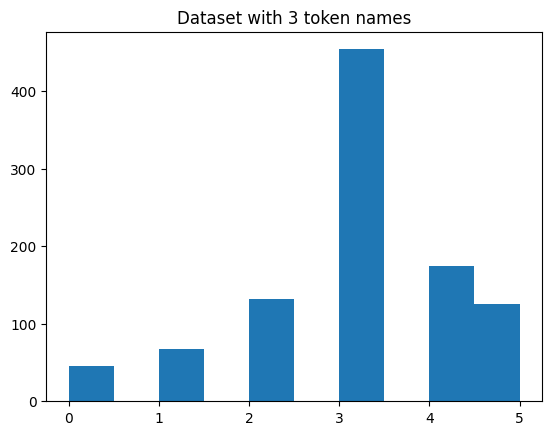

In [76]:
import matplotlib.pyplot as plt

for idx, ds in enumerate(datasets):
    plt.hist(ds["prompt_type"])
    plt.title(f"Dataset with {idx+1} token names")
    plt.show()